<a href="https://colab.research.google.com/github/orifelszer/CrimeData/blob/eden-branch/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
import os
import zipfile

# הורדת הנתונים מה-GitHub
!git clone https://github.com/orifelszer/CrimeData.git

# הגדרת התיקייה לאחר ההורדה
zip_folder = 'CrimeData'

# הגדרת נתיבים ישירים לשני הקבצים
zip_files = [
    os.path.join(zip_folder, 'Clean_data_unsupervised_part1.zip'),
    os.path.join(zip_folder, 'Clean_data_unsupervised_part2.zip')
]

# רשימה לשמירת נתיבי הקבצים שנפרסו
extracted_folders = []

# פריסת קבצי ה-ZIP
for zip_file in zip_files:
    extract_path = zip_file.replace('.zip', '')  # יצירת שם תיקייה לפי שם הקובץ

    # בדיקה אם הקובץ קיים
    if os.path.exists(zip_file):
        # בדיקה אם התיקייה כבר נפרסה
        if not os.path.exists(extract_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Extracted: {zip_file} -> {extract_path}")
        else:
            print(f"Skipped: {zip_file} (Already extracted)")
    else:
        print(f"File not found: {zip_file}")

    extracted_folders.append(extract_path)

# איחוד קבצי CSV שפורסו
dataframes = []

for folder in extracted_folders:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name.endswith('.csv'):
            df_temp = pd.read_csv(file_path)
            dataframes.append(df_temp)

# איחוד כל הנתונים למסגרת נתונים אחת
combined_df = pd.concat(dataframes, ignore_index=True)

# הצגת מסגרת הנתונים המאוחדת
print(f"Combined dataset contains {combined_df.shape[0]} rows and {combined_df.shape[1]} columns.")

Cloning into 'CrimeData'...
remote: Enumerating objects: 898, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 898 (delta 265), reused 149 (delta 149), pack-reused 554 (from 1)
Receiving objects: 100% (898/898), 298.67 MiB | 32.90 MiB/s, done.
Resolving deltas: 100% (474/474), done.
Extracted: CrimeData/Clean_data_unsupervised_part1.zip -> CrimeData/Clean_data_unsupervised_part1
Extracted: CrimeData/Clean_data_unsupervised_part2.zip -> CrimeData/Clean_data_unsupervised_part2
Combined dataset contains 1686927 rows and 19 columns.


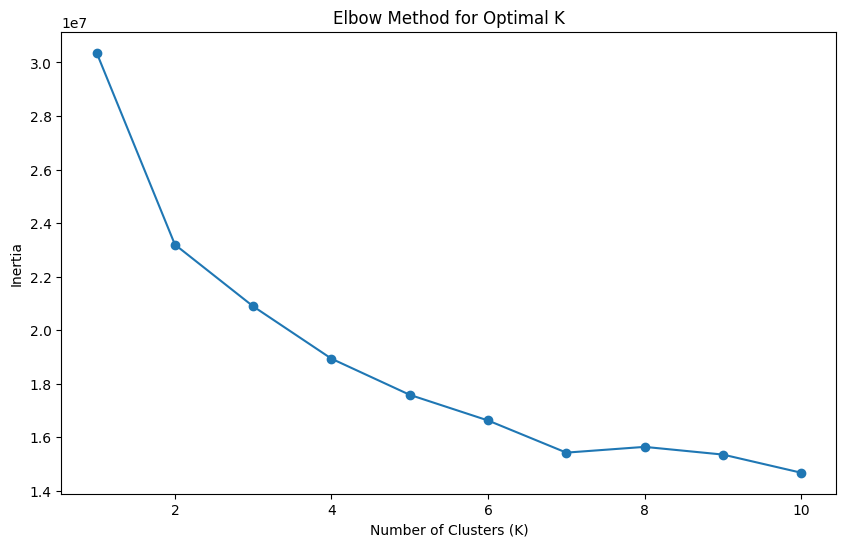

In [3]:
# הסרת עמודת המזהה עבור אשכולות
df_kmeans = combined_df.drop(columns=['FictiveIDNumber'])

# ביצוע סטנדרטיזציה על הנתונים (חשוב עבור K-Means)
scaler = StandardScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

# בחינת מספר אשכולות מתאים באמצעות Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# הצגת גרף Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


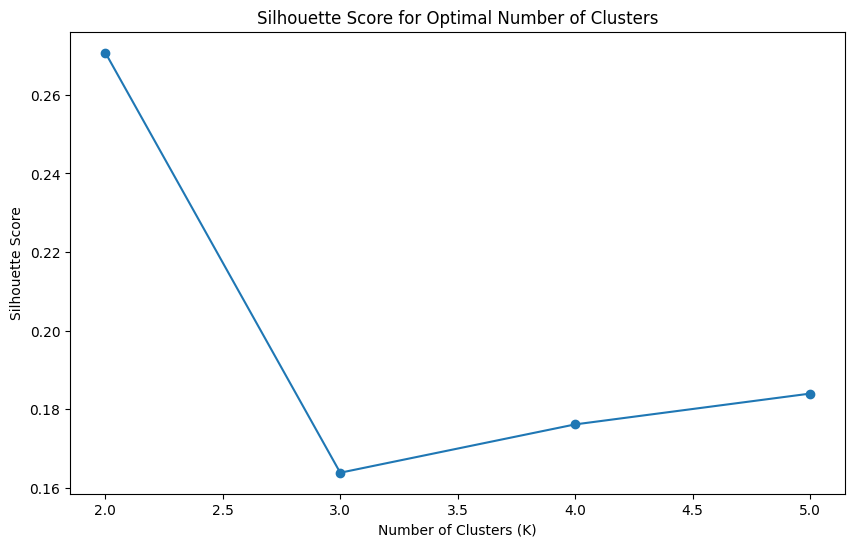

Optimal number of clusters based on Silhouette Score: 2


In [11]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ✅ דגימה רנדומלית של 50,000 דוגמאות כדי לחסוך זמן ריצה
sample_size = min(50000, df_kmeans_scaled.shape[0])
indices = np.random.choice(df_kmeans_scaled.shape[0], sample_size, replace=False)
df_sample = df_kmeans_scaled[indices]

# ✅ חישוב Silhouette Score עבור ערכי K מ-2 עד 10
silhouette_scores = []
k_values = range(2, 6)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample)
    score = silhouette_score(df_sample, cluster_labels)
    silhouette_scores.append(score)

# ✅ גרף להצגת Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

# ✅ הצגת מספר האשכולות האופטימלי לפי Silhouette
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k_silhouette}")


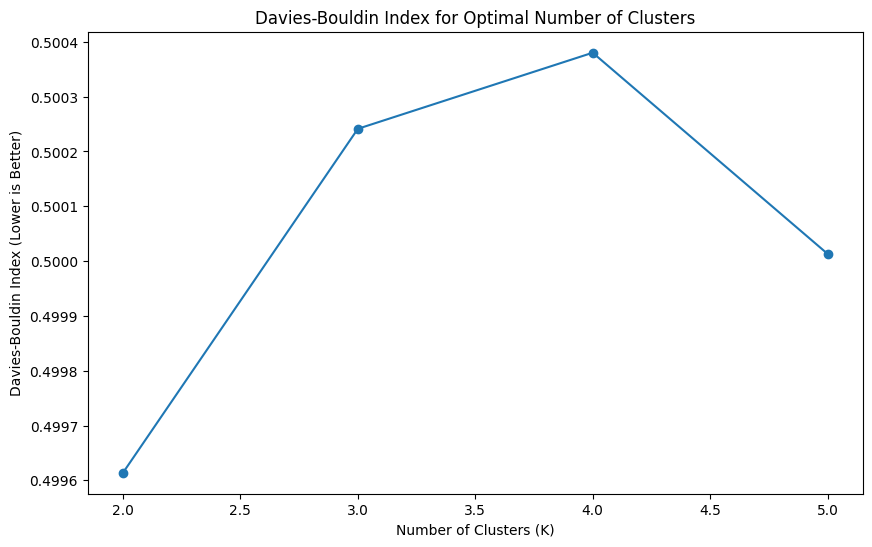

Optimal number of clusters based on Davies-Bouldin Index: 2


In [13]:
from sklearn.metrics import davies_bouldin_score

# ✅ חישוב מדד Davies-Bouldin עבור K=2 עד 10
davies_bouldin_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_df)
    score = davies_bouldin_score(combined_df, cluster_labels)
    davies_bouldin_scores.append(score)

# ✅ גרף להצגת Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index (Lower is Better)')
plt.show()

# ✅ קביעת K האופטימלי לפי המדד (נמוך יותר טוב יותר)
optimal_k_db = k_values[np.argmin(davies_bouldin_scores)]
print(f"Optimal number of clusters based on Davies-Bouldin Index: {optimal_k_db}")


In [15]:
from sklearn.cluster import DBSCAN

# הרצת DBSCAN על דגימה
dbscan = DBSCAN(eps=1.0, min_samples=20)
dbscan_labels = dbscan.fit_predict(df_sample)
unique_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters detected by DBSCAN: {unique_clusters}")

Number of clusters detected by DBSCAN: 269


In [16]:
from sklearn.cluster import DBSCAN
import numpy as np

# בדיקה של מספר ערכי eps והשפעתם
eps_values = [0.5, 1.0, 1.5, 2.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=20)
    dbscan_labels = dbscan.fit_predict(df_sample)
    unique_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    print(f"DBSCAN with eps={eps}: Number of Clusters Detected: {unique_clusters}")


DBSCAN with eps=0.5: Number of Clusters Detected: 102
DBSCAN with eps=1.0: Number of Clusters Detected: 269
DBSCAN with eps=1.5: Number of Clusters Detected: 100
DBSCAN with eps=2.0: Number of Clusters Detected: 42


In [ ]:
# בדיקה של ערכי eps גבוהים יותר
eps_values = [2.5, 3.0, 3.5, 4.0, 5.0]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=20)
    dbscan_labels = dbscan.fit_predict(df_sample)
    unique_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    noise_points = np.sum(dbscan_labels == -1)
    total_points = len(dbscan_labels)
    noise_percentage = (noise_points / total_points) * 100
    print(f"DBSCAN with eps={eps}: Number of Clusters: {unique_clusters}, Noise: {noise_percentage:.2f}%")


DBSCAN with eps=2.5: Number of Clusters: 7, Noise: 0.27%
DBSCAN with eps=3.0: Number of Clusters: 7, Noise: 0.01%
DBSCAN with eps=3.5: Number of Clusters: 2, Noise: 0.01%
DBSCAN with eps=4.0: Number of Clusters: 2, Noise: 0.00%


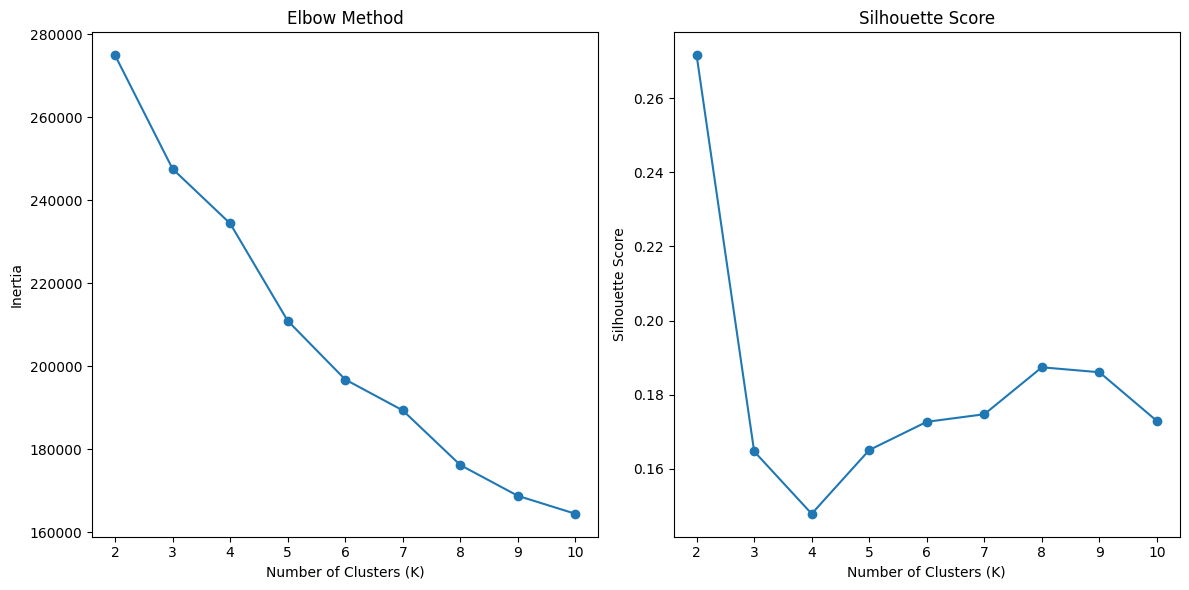

Silhouette Score for DBSCAN: -0.27707409472694233


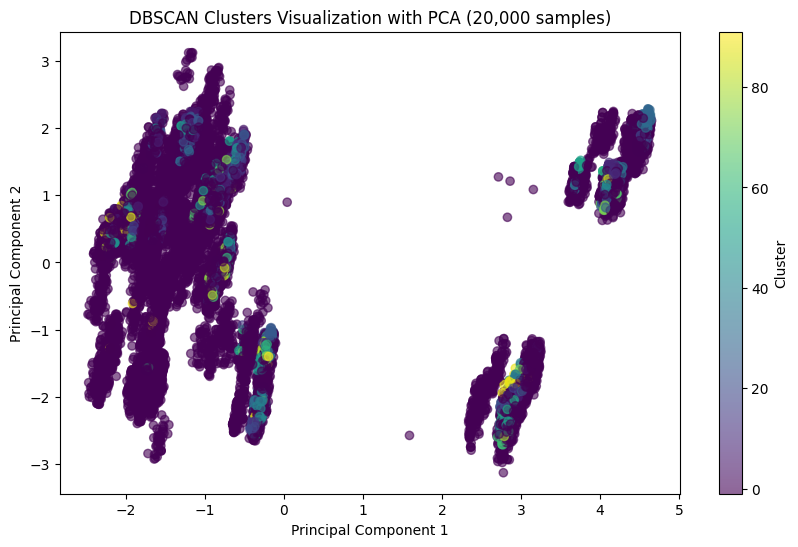

In [8]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# ✅ דגימה רנדומלית ל-20,000 דוגמאות בלבד כדי למנוע עומס חישובי
sample_size = min(20000, df_kmeans_scaled.shape[0])
indices = np.random.choice(df_kmeans_scaled.shape[0], sample_size, replace=False)
df_sample = df_kmeans_scaled[indices]

# ✅ בדיקת Elbow Method + Silhouette עם דגימה קטנה
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_sample)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(df_sample, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# ✅ הצגת גרף Elbow
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')

# ✅ הצגת גרף Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# ✅ ביצוע DBSCAN עם דגימה קטנה (20,000 דוגמאות)
dbscan = DBSCAN(eps=1.0, min_samples=20, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_sample)

# ✅ חישוב סילואט עבור DBSCAN (אם זוהו יותר מאשכול אחד)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(df_sample, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {dbscan_silhouette}")
else:
    print("DBSCAN זיהה רק אשכול אחד או שרוב הדגימות מסומנות כרעש (Noise).")

# ✅ ויזואליזציה של DBSCAN עם PCA (2 רכיבים בלבד)
pca = PCA(n_components=2)
df_pca_2d_dbscan = pca.fit_transform(df_sample)

plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_dbscan[:, 0], df_pca_2d_dbscan[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clusters Visualization with PCA (20,000 samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [9]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

### ---- שלב 1: K-Means על כל הדאטה ----
optimal_k = 4  # בהתבסס על גרף ה-Elbow שלך
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(df_kmeans_scaled)

# חישוב מדדי הערכה ל-K-Means
kmeans_silhouette = silhouette_score(df_kmeans_scaled, kmeans_labels)
kmeans_db_index = davies_bouldin_score(df_kmeans_scaled, kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db_index:.3f}")

# ויזואליזציה עם PCA עבור K-Means
pca_kmeans = PCA(n_components=2)
df_pca_2d_kmeans = pca_kmeans.fit_transform(df_kmeans_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_kmeans[:, 0], df_pca_2d_kmeans[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('K-Means Clusters Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

### ---- שלב 2: DBSCAN על דגימה מופחתת ----
sample_size = min(20000, df_kmeans_scaled.shape[0])
indices = np.random.choice(df_kmeans_scaled.shape[0], sample_size, replace=False)
df_sample = df_kmeans_scaled[indices]

# DBSCAN עם פרמטרים מותאמים לנתונים גדולים
dbscan = DBSCAN(eps=1.0, min_samples=20, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_sample)

# חישוב מדדי הערכה עבור DBSCAN (רק אם יש יותר מאשכול אחד)
if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(df_sample, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(df_sample, dbscan_labels)
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_db_index:.3f}")
else:
    print("DBSCAN זיהה רק אשכול אחד או שכל הנתונים סומנו כרעש (Noise).")

# ויזואליזציה עם PCA עבור DBSCAN
pca_dbscan = PCA(n_components=2)
df_pca_2d_dbscan = pca_dbscan.fit_transform(df_sample)

plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_dbscan[:, 0], df_pca_2d_dbscan[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clusters Visualization with PCA (20,000 samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

### ---- שלב 3: סיכום תוצאות ----
print("\n📊 **סיכום מדדים:**")
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db_index:.3f}")
if len(set(dbscan_labels)) > 1:
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_db_index:.3f}")
else:
    print("DBSCAN לא זיהה אשכולות בצורה מספקת.")


KeyboardInterrupt: 

In [4]:
# אימון מודל K-Means עם מספר אשכולות אופטימלי (K=4)
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df_kmeans['Cluster'] = kmeans_final.fit_predict(df_kmeans_scaled)

# הצגת מספר דוגמאות מהנתונים עם תגי האשכולות
print("Data with Cluster Labels:")
df_kmeans.head()

Data with Cluster Labels:


,Year,Yeshuv,PoliceDistrict,PoliceMerhav,PoliceStation,StatisticArea,StatisticGroup,StatisticType,Quarter_numeric,Quarter_sin,Quarter_cos,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount,CityOrMoshav_Moshav,Cluster
0,2020,50,3,19,50,1236,10,14,1,1.000000e+00,6.123234e-17,0.596563,4.523112,0.553678,0.601860,0.596563,4.50001,False,2
1,2020,70,3,18,63,704,3,97,2,1.224647e-16,-1.000000e+00,0.625726,4.523112,0.580618,0.631580,0.625726,4.50001,False,2
2,2020,21,6,8,15,194,10,121,4,-2.449294e-16,1.000000e+00,0.266477,4.523112,0.248758,0.214669,0.266477,3.50001,True,3
3,2020,33,2,15,40,246,4,27,2,1.224647e-16,-1.000000e+00,2.364671,4.523112,2.186987,2.424294,2.364671,2.00001,False,1
4,2020,33,2,15,35,1080,9,1,2,1.224647e-16,-1.000000e+00,2.364671,4.523112,2.186987,2.340074,2.364671,2.00001,False,1


Davies-Bouldin Index for K=4: 1.9390606126381325


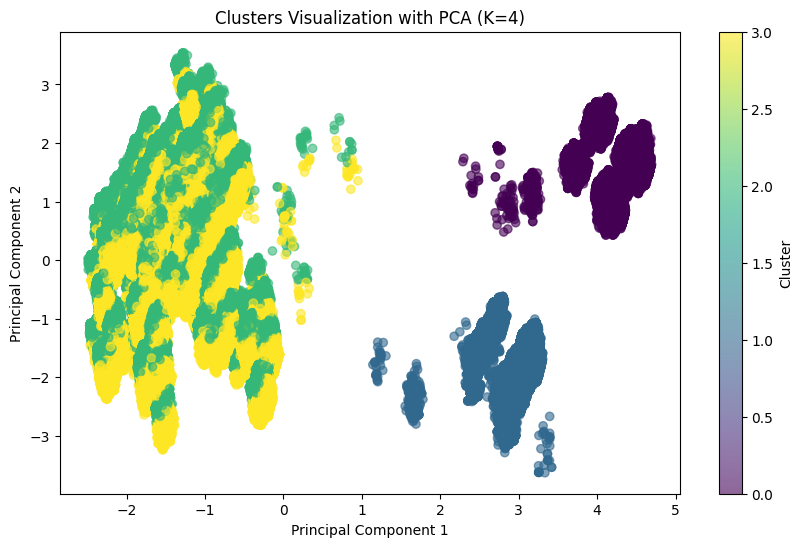

In [6]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# ביצוע קלאסטרינג עם K=4 לפי גרף המרפק
kmeans_final = KMeans(n_clusters=4, random_state=42)
cluster_labels_final = kmeans_final.fit_predict(df_kmeans_scaled)

# חישוב Davies-Bouldin Index
db_index = davies_bouldin_score(df_kmeans_scaled, cluster_labels_final)
print(f"Davies-Bouldin Index for K=4: {db_index}")

# ויזואליזציה עם PCA ל-2 מימדים
pca = PCA(n_components=2)  # הפחתה ל-2 רכיבים עיקריים
df_pca_2d = pca.fit_transform(df_kmeans_scaled)

# ציור אשכולות
plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d[:, 0], df_pca_2d[:, 1], c=cluster_labels_final, cmap='viridis', alpha=0.6)
plt.title('Clusters Visualization with PCA (K=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


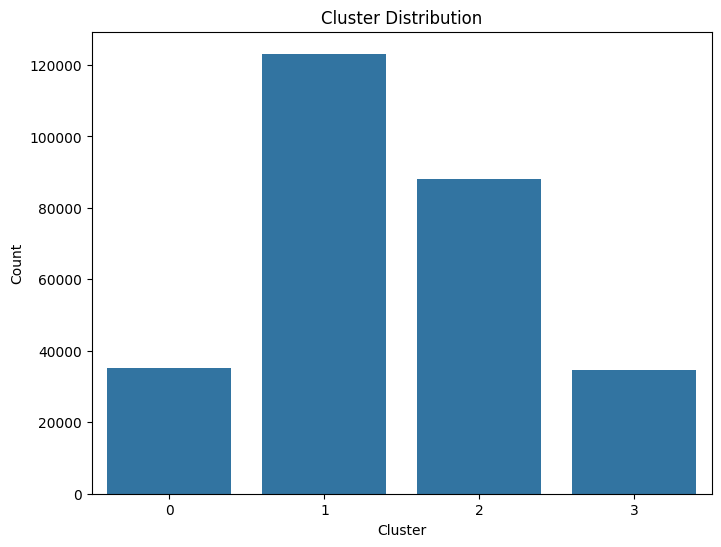

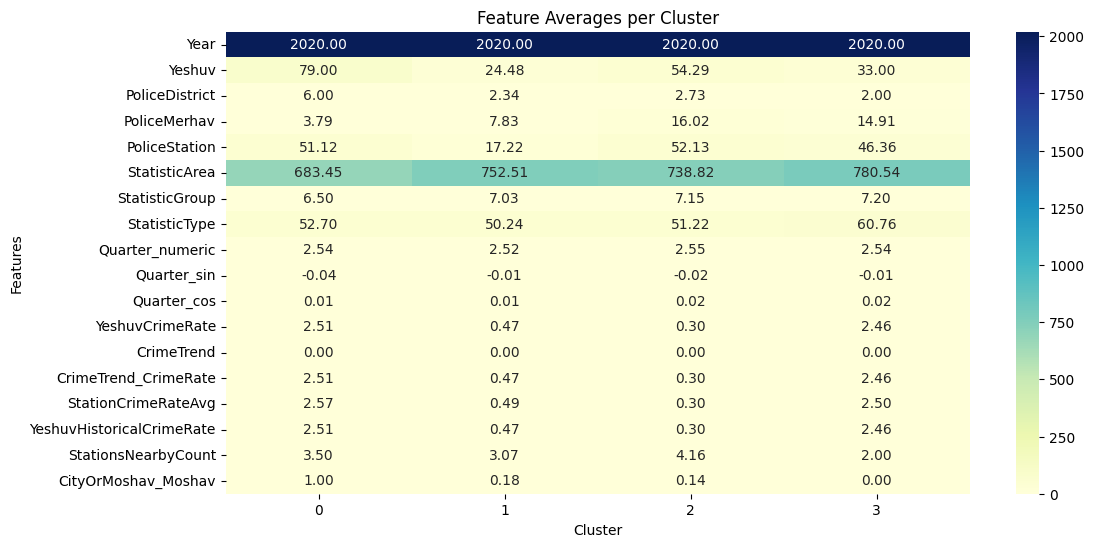

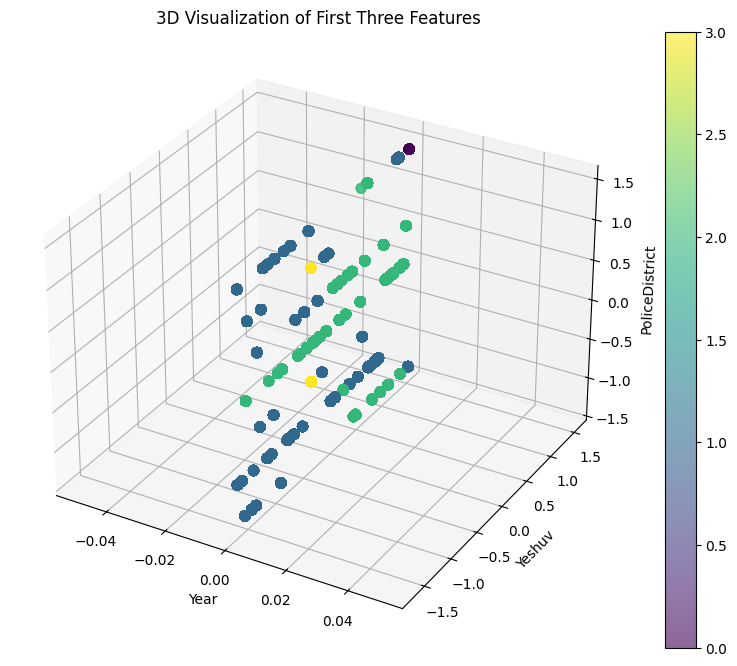

In [ ]:
import seaborn as sns

# ✅ התפלגות האשכולות
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=df_kmeans)
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

# ✅ ממוצע משתנים לפי אשכול
cluster_means = df_kmeans.groupby('Cluster').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.transpose(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Feature Averages per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

# ✅ הדמיה תלת-ממדית של 3 התכונות הראשונות
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_kmeans_scaled[:, 0], df_kmeans_scaled[:, 1], df_kmeans_scaled[:, 2],
    c=combined_df['Cluster'], cmap='viridis', s=50, alpha=0.6
)
ax.set_title('3D Visualization of First Three Features')
ax.set_xlabel(df_kmeans.columns[0])
ax.set_ylabel(df_kmeans.columns[1])
ax.set_zlabel(df_kmeans.columns[2])
plt.colorbar(scatter)
plt.show()


In [ ]:
# הגדרת רשימות העמודות לפי מה שהגדרת
categorical_cols = [
    'Year', 'Yeshuv', 'PoliceDistrict', 'PoliceMerhav', 'PoliceStation',
    'StatisticArea', 'StatisticGroup', 'StatisticType', 'Quarter_numeric', 'CityOrMoshav_Moshav'
]

cyclical_cols = ['Quarter_sin', 'Quarter_cos']

numeric_cols = [
    'YeshuvCrimeRate', 'CrimeTrend', 'CrimeTrend_CrimeRate',
    'StationCrimeRateAvg', 'YeshuvHistoricalCrimeRate', 'StationsNearbyCount'
]

# ✅ חישוב ממוצע לעמודות מספריות בלבד
numeric_means = df_kmeans[numeric_cols].groupby(df_kmeans['Cluster']).mean()

# ✅ חישוב ממוצע לעמודות מחזוריות (נחשבות מספריות)
cyclical_means = df_kmeans[cyclical_cols].groupby(df_kmeans['Cluster']).mean()

# ✅ חישוב שכיח (Mode) לעמודות קטגוריאליות בלבד
categorical_modes = df_kmeans[categorical_cols].groupby(df_kmeans['Cluster']).agg(lambda x: x.mode()[0])

# ✅ איחוד כל התוצאות לטבלה אחת מסודרת
cluster_summary = pd.concat([numeric_means, cyclical_means, categorical_modes], axis=1)

# ✅ הצגת התוצאות ישירות במחברת עם Pandas
print("Cluster Summary (Numeric Means and Categorical Modes):")
display(cluster_summary)


Cluster Summary (Numeric Means and Categorical Modes):


,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount,Quarter_sin,Quarter_cos,Year,Yeshuv,PoliceDistrict,PoliceMerhav,PoliceStation,StatisticArea,StatisticGroup,StatisticType,Quarter_numeric,CityOrMoshav_Moshav
Cluster,,,,,,,,,,,,,,,,,,
0,2.512516,0.0,2.512516,2.572608,2.512516,3.500010,-0.035088,0.011375,2020,79,6,0,36,866,4,23,3,True
1,0.473803,0.0,0.473803,0.492446,0.473803,3.070571,-0.010411,0.005847,2020,8,1,13,7,833,10,14,4,False
2,0.295060,0.0,0.295060,0.300572,0.295060,4.160627,-0.024181,0.016223,2020,69,3,19,63,1479,10,14,4,False
3,2.462061,0.0,2.462061,2.496758,2.462061,1.999199,-0.014885,0.021198,2020,33,2,15,40,1361,10,1,4,False


In [ ]:
df_kmeans

,Year,Yeshuv,PoliceDistrict,PoliceMerhav,PoliceStation,StatisticArea,StatisticGroup,StatisticType,Quarter_numeric,Quarter_sin,Quarter_cos,YeshuvCrimeRate,CrimeTrend,CrimeTrend_CrimeRate,StationCrimeRateAvg,YeshuvHistoricalCrimeRate,StationsNearbyCount,CityOrMoshav_Moshav,Cluster
0,2020,49,3,19,50,1209,10,14,1,1.000000e+00,6.123234e-17,0.577090,0.0,0.577090,0.589588,0.577090,4.50001,False,2
1,2020,69,3,18,63,681,3,87,2,1.224647e-16,-1.000000e+00,0.597588,0.0,0.597588,0.610413,0.597588,4.50001,False,2
2,2020,21,6,8,15,186,10,110,4,-2.449294e-16,1.000000e+00,0.287260,0.0,0.287260,0.242119,0.287260,3.50001,True,1
3,2020,33,2,15,40,235,4,25,2,1.224647e-16,-1.000000e+00,2.462061,0.0,2.462061,2.525477,2.462061,2.00001,False,4
4,2020,33,2,15,35,1053,9,1,2,1.224647e-16,-1.000000e+00,2.462061,0.0,2.462061,2.423307,2.462061,2.00001,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281133,2020,8,0,13,7,398,9,1,3,-1.000000e+00,-1.836970e-16,1.175385,0.0,1.175385,1.204044,1.175385,3.00001,False,3
281134,2020,72,3,18,66,193,9,1,2,1.224647e-16,-1.000000e+00,0.310911,0.0,0.310911,0.316215,0.310911,4.50001,False,2
281135,2020,14,6,0,12,139,9,1,1,1.000000e+00,6.123234e-17,0.487145,0.0,0.487145,0.497212,0.487145,3.50001,False,1
281136,2020,75,3,19,32,467,10,112,1,1.000000e+00,6.123234e-17,0.110882,0.0,0.110882,0.146076,0.110882,4.50001,False,2


In [ ]:
df_kmeans.groupby('Cluster')['YeshuvCrimeRate'].mean()


,YeshuvCrimeRate
Cluster,
0,2.512516
1,0.229975
2,0.300148
3,0.715565
4,2.462061


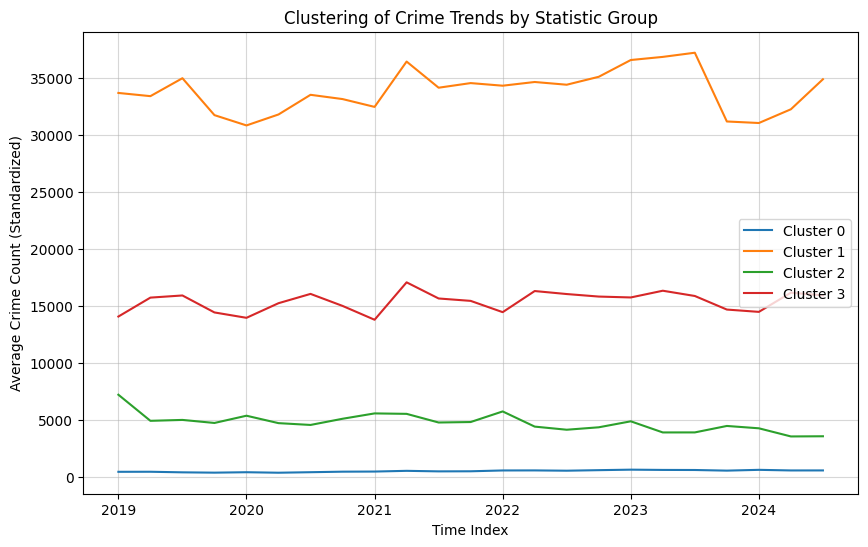

In [ ]:
# # Clustering with K-Means
# kmeans = KMeans(n_clusters=4, random_state=42)
# clusters = kmeans.fit_predict(crime_pivot_scaled)

# # Add cluster labels to the original StatisticGroup data
# crime_pivot['Cluster'] = clusters



# # Visualization: Clustering Results
# plt.figure(figsize=(10, 6))
# for cluster in range(kmeans.n_clusters):
#     cluster_data = crime_pivot[crime_pivot['Cluster'] == cluster]
#     plt.plot(cluster_data.columns[:-2], cluster_data.iloc[:, :-2].mean(axis=0), label=f'Cluster {cluster}')

# plt.title('Clustering of Crime Trends by Statistic Group')
# plt.xlabel('Time Index')
# plt.ylabel('Average Crime Count (Standardized)')
# plt.legend()
# plt.grid(alpha=0.5)
# plt.show()



Clusters Overview:
Cluster 0 (Blue Line):

Represents statistic groups with the lowest crime counts over the entire period.
These groups remain consistently low and do not show significant variation over time.
Possible examples: Rare or less-reported crime types.
Cluster 1 (Orange Line):

Represents statistic groups with the highest crime counts.
Shows consistent activity over time but has notable peaks and dips:
The dip in 2020 aligns with COVID-19.
The drop in 2023 corresponds to the Israeli war.
Likely includes high-frequency crimes such as theft or property-related offenses.
Cluster 2 (Green Line):

Represents statistic groups with moderate but lower counts compared to Cluster 1.
The trend is relatively stable, with slight fluctuations.
Possible examples: Crimes that occur periodically, such as fraud or vandalism.
Cluster 3 (Red Line):

Represents statistic groups with medium-to-high crime counts.
Fluctuations are more prominent compared to Cluster 2, suggesting greater variability in occurrence.
Potentially includes crime types influenced by specific events or seasonal factors, such as violent crimes or drug-related offenses.
Key Insights:
Cluster 1 (Orange Line):

Dominates the overall trend, highlighting that a few statistic groups account for the majority of crimes.
Drops during major disruptions (COVID-19, war) suggest these are crimes dependent on normal societal activity (e.g., theft).
Cluster 3 (Red Line):

Fluctuations indicate these crimes might be more sensitive to external factors or enforcement actions.
Cluster 2 and Cluster 0:

Remain relatively stable and low, reflecting crimes that are either rare (Cluster 0) or less influenced by external events (Cluster 2).
How to Use This Insight:
Prioritize Resources:

Focus law enforcement efforts on statistic groups in Cluster 1 due to their high volume.
Monitor Cluster 3 for patterns that might indicate emerging risks.
Analyze Events:

Dive deeper into statistic groups in Clusters 1 and 3 to understand what causes their trends (e.g., policy changes, holidays, or major events).

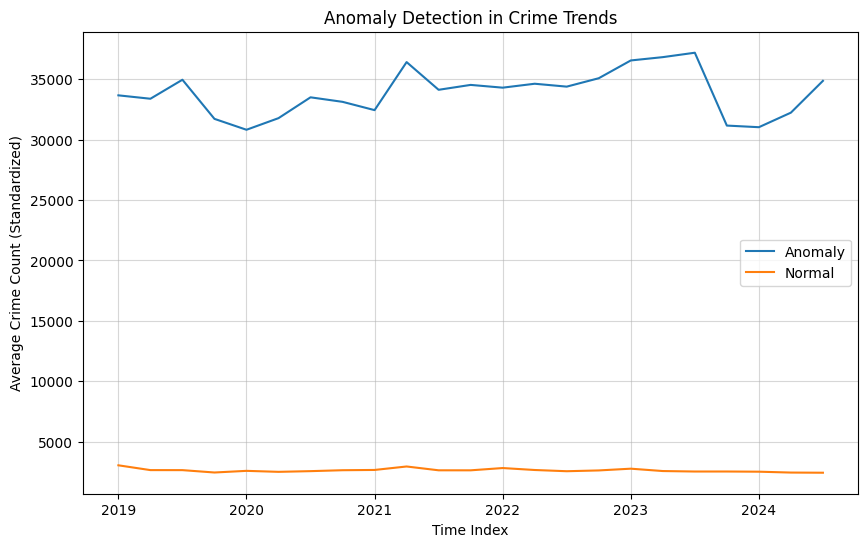

In [ ]:
# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.1)
anomalies = iso_forest.fit_predict(crime_pivot_scaled)
crime_pivot['Anomaly'] = anomalies
# Visualization: Anomalies
plt.figure(figsize=(10, 6))
for anomaly in [-1, 1]:
    anomaly_data = crime_pivot[crime_pivot['Anomaly'] == anomaly]
    anomaly_label = 'Anomaly' if anomaly == -1 else 'Normal'
    plt.plot(anomaly_data.columns[:-2], anomaly_data.iloc[:, :-2].mean(axis=0), label=anomaly_label)

plt.title('Anomaly Detection in Crime Trends')
plt.xlabel('Time Index')
plt.ylabel('Average Crime Count (Standardized)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


COVID-19 in 2020:
Decreased Crime Rates:

During COVID-19 lockdowns, restrictions on movement likely reduced opportunities for crimes such as theft, burglary, and street violence.
Many countries observed similar declines in crime rates during the pandemic.
Possible Impact on the Graph:

The drop in anomalies around 2020 aligns with this period.
This suggests a reduction in unusual spikes in crime, likely due to the overall decrease in criminal activities during the pandemic.
Israel War (October 7, 2023):
Decreased Crime Rates During Conflict:

During wartime, the focus shifts to survival and defense, and normal societal activities are disrupted.
Law enforcement and public resources are often redirected toward managing the crisis, potentially reducing reported crimes like theft and public order violations.
Impact Seen in the Graph:

A sharp drop in anomalies around late 2023 matches the war's timeline.
This could indicate:
Fewer reported crimes during this time due to disrupted normal life.
The population and authorities focusing on safety and survival rather than everyday criminal activities.

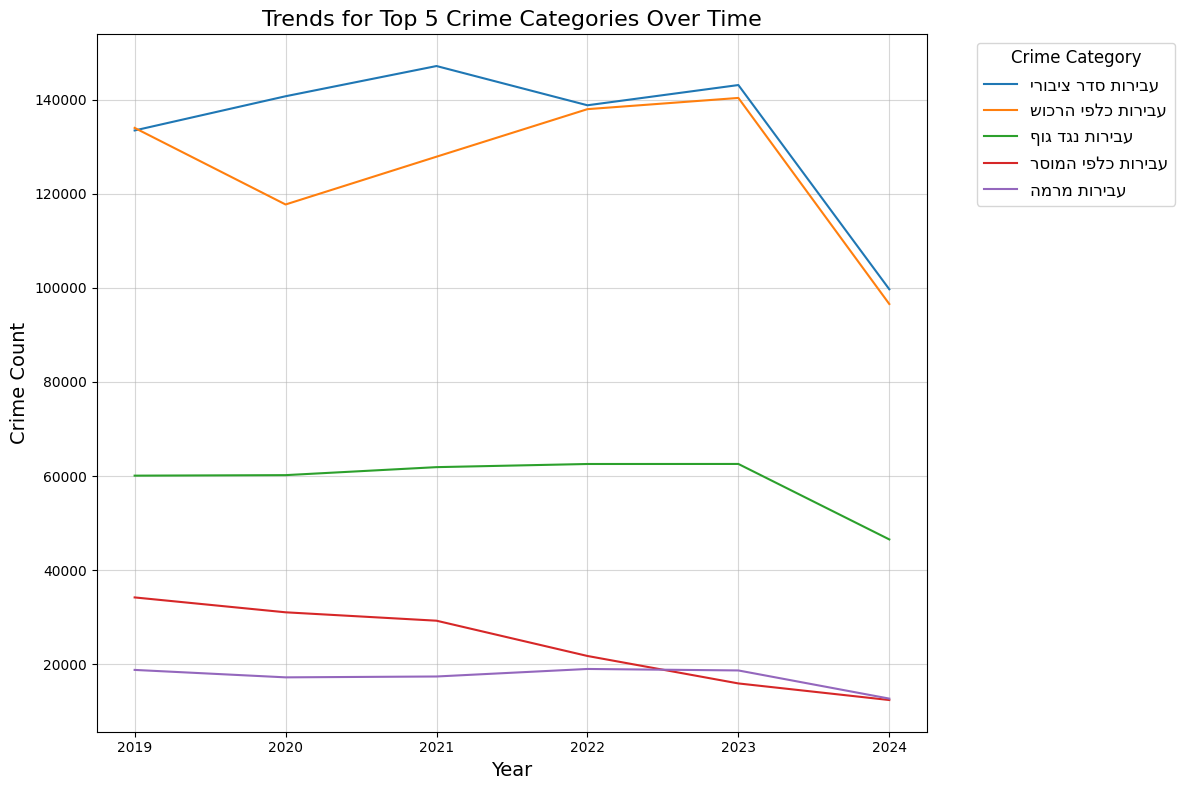

In [ ]:
#!pip install python-bidi

import matplotlib.pyplot as plt
from bidi.algorithm import get_display  # Corrects text orientation
from matplotlib import rcParams
from matplotlib import font_manager

# Set font that supports Hebrew and configure matplotlib
rcParams['font.family'] = 'DejaVu Sans'
rcParams['axes.unicode_minus'] = False

# Correcting the mirrored Hebrew using `bidi`
top_categories_display = [get_display(category) for category in top_categories]

# Replot the graph with fixed labels
plt.figure(figsize=(12, 8))

for category, category_display in zip(top_categories, top_categories_display):
    category_data = top_category_trends[top_category_trends['StatisticGroup'] == category]
    plt.plot(category_data['Year'], category_data['CrimeCount'], label=category_display)

# Customize the plot
plt.title(get_display('Trends for Top 5 Crime Categories Over Time'), fontsize=16)
plt.xlabel(get_display('Year'), fontsize=14)
plt.ylabel(get_display('Crime Count'), fontsize=14)
plt.legend(
    title=get_display('Crime Category'),
    fontsize=12,
    loc='upper left',
    title_fontsize=12,
    bbox_to_anchor=(1.05, 1)
)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


